# Simple DistilBERT Multi-Column Classifier

This notebook trains **DistilBERT** to predict **experience_level** (junior/mid/senior) from resume data.

**Approach:**
- Uses **all columns** from the CSV (no exclusions)
- Each column is tokenized separately
- Simple multi-class classification with CrossEntropyLoss
- Straightforward training and evaluation

In [ ]:
# Imports and Configuration
import csv
import random
from collections import Counter
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, DistilBertModel, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Configuration
DATA_PATH = Path("cleaned_resumes.csv")
LABEL_COL = "experience_level"
MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 128  # Reduced for efficiency
SEED = 42
TRAIN_RATIO = 0.8
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
WEIGHT_DECAY = 0.01

# Setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Device: {DEVICE}")
print(f"Data path: {DATA_PATH.resolve()}")


device: cuda
data: C:\Users\Rane\Desktop\GenAI Baseline\SeniortyPrediction\Smaller Models\cleaned_resumes.csv


# Load Data


In [ ]:
# Load CSV data
with DATA_PATH.open(newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    rows = list(reader)
    columns = reader.fieldnames

# Get all columns except the label (NO EXCLUSIONS)
FEATURE_COLUMNS = [c for c in columns if c != LABEL_COL]

# Extract labels
labels = [str(r[LABEL_COL]).strip().lower() for r in rows]
label_counts = Counter(labels)

# Create label mappings
label_names = sorted(label_counts.keys())
label2id = {name: i for i, name in enumerate(label_names)}
id2label = {i: name for name, i in label2id.items()}

print(f"Total rows: {len(rows)}")
print(f"Feature columns ({len(FEATURE_COLUMNS)}): {FEATURE_COLUMNS}")
print(f"Label distribution: {dict(label_counts)}")
print(f"Label mapping: {label2id}")


rows: 2100
feature_columns (count): 12
feature_columns: ['summary', 'experience', 'education', 'skills', 'projects', 'certifications', 'summary_count', 'last_experience_only', 'total_experience_time', 'last_experience_time', 'job title', 'target_experience_text']
label_counts: {'senior': 700, 'mid': 700, 'junior': 700}

most_empty_columns (top 8):
- name: 0.0%
- email: 0.0%
- summary: 0.0%
- linkedin: 0.0%
- github: 0.0%
- experience: 0.0%
- education: 0.0%
- skills: 0.0%

example rows (label + 3 columns):
[0] label='senior' preview={'summary': 'Passionate Deep Learning Engineer with expertise in neural network design, train', 'experience': 'Experience 1: Company: Smith-Bennett. Title: deep learning engineer. Level: juni', 'education': 'Education 1: Degree Level: MSc. Field: Computer Science. Major: Deep. Institutio'}
[1] label='senior' preview={'summary': 'Blockchain Developer with experience in smart contract development and integrati', 'experience': 'Experience 1: Company: Nelson-Da

# Tokenize and Split Data


In [ ]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Convert labels to tensor
y = torch.tensor([label2id[l] for l in labels], dtype=torch.long)

# Tokenize each column separately
input_ids_cols = []
attention_mask_cols = []

for col in FEATURE_COLUMNS:
    texts = [str(r.get(col, "") or "") for r in rows]
    encoded = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt"
    )
    input_ids_cols.append(encoded["input_ids"])
    attention_mask_cols.append(encoded["attention_mask"])

# Stack to create [N, num_columns, MAX_LEN] tensors
input_ids = torch.stack(input_ids_cols, dim=1)
attention_mask = torch.stack(attention_mask_cols, dim=1)

print(f"Input shape: {tuple(input_ids.shape)} [samples, columns, seq_length]")
print(f"Labels shape: {tuple(y.shape)}")

# Stratified train/val split
rng = random.Random(SEED)
indices_by_label = {name: [] for name in label_names}
for i, lab in enumerate(labels):
    indices_by_label[lab].append(i)

train_idx, val_idx = [], []
for lab, idxs in indices_by_label.items():
    rng.shuffle(idxs)
    split_point = int(len(idxs) * TRAIN_RATIO)
    train_idx.extend(idxs[:split_point])
    val_idx.extend(idxs[split_point:])

rng.shuffle(train_idx)
rng.shuffle(val_idx)

# Create train/val datasets
train_input_ids = input_ids[train_idx]
train_attention_mask = attention_mask[train_idx]
train_y = y[train_idx]

val_input_ids = input_ids[val_idx]
val_attention_mask = attention_mask[val_idx]
val_y = y[val_idx]

print(f"\nTrain: {len(train_idx)} samples - {Counter([labels[i] for i in train_idx])}")
print(f"Val: {len(val_idx)} samples - {Counter([labels[i] for i in val_idx])}")


input_ids: (2100, 12, 256)
attention_mask: (2100, 12, 256)
labels: (2100,)

train size: 1680 Counter({'junior': 560, 'mid': 560, 'senior': 560})
val size: 420 Counter({'senior': 140, 'mid': 140, 'junior': 140})


# Create DataLoaders


In [ ]:
class ResumeDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.labels[idx]

# Create datasets and dataloaders
train_ds = ResumeDataset(train_input_ids, train_attention_mask, train_y)
val_ds = ResumeDataset(val_input_ids, val_attention_mask, val_y)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


batch input_ids: (16, 12, 256)
batch attention_mask: (16, 12, 256)
batch labels: (16,)


# Define Simple Multi-Column Model


In [ ]:
class SimpleMultiColumnClassifier(nn.Module):
    """Simple multi-class classifier for resume experience level prediction."""
    
    def __init__(self, model_name, num_columns, num_classes, dropout=0.1):
        super().__init__()
        self.encoder = DistilBertModel.from_pretrained(model_name)
        self.hidden_size = self.encoder.config.hidden_size
        
        # Simple classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.hidden_size, num_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        # input_ids: [batch, num_columns, seq_len]
        # attention_mask: [batch, num_columns, seq_len]
        
        batch_size, num_cols, seq_len = input_ids.shape
        
        # Flatten to process all columns at once
        flat_ids = input_ids.view(batch_size * num_cols, seq_len)
        flat_mask = attention_mask.view(batch_size * num_cols, seq_len)
        
        # Encode with DistilBERT
        outputs = self.encoder(input_ids=flat_ids, attention_mask=flat_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [batch*num_cols, hidden]
        
        # Reshape back and average across columns
        cls_embeddings = cls_embeddings.view(batch_size, num_cols, self.hidden_size)
        pooled = cls_embeddings.mean(dim=1)  # [batch, hidden]
        
        # Classify
        logits = self.classifier(pooled)  # [batch, num_classes]
        return logits

# Initialize model
NUM_COLUMNS = len(FEATURE_COLUMNS)
NUM_CLASSES = len(label2id)

model = SimpleMultiColumnClassifier(
    model_name=MODEL_NAME,
    num_columns=NUM_COLUMNS,
    num_classes=NUM_CLASSES
).to(DEVICE)

print(f"Model initialized with {NUM_COLUMNS} columns and {NUM_CLASSES} classes")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


logits: (16, 2)


# Training Loop


In [ ]:
# Setup training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

total_steps = EPOCHS * len(train_loader)
warmup_steps = total_steps // 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

def evaluate_model(model, loader):
    """Evaluate model on a dataset."""
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    
    with torch.no_grad():
        for input_ids, attention_mask, labels in loader:
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            labels = labels.to(DEVICE)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    
    return avg_loss, accuracy, f1_macro, f1_per_class, all_preds, all_labels

# Training loop
print("Starting training...\n")
best_val_f1 = 0.0
best_model_path = Path("best_simple_distilbert.pt")

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (input_ids, attention_mask, labels) in enumerate(train_loader):
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    
    train_acc = train_correct / train_total
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation
    val_loss, val_acc, val_f1_macro, val_f1_per_class, _, _ = evaluate_model(model, val_loader)
    
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1 (macro): {val_f1_macro:.4f}")
    print(f"  Val F1 per class: {[f'{f:.3f}' for f in val_f1_per_class]}")
    
    # Save best model
    if val_f1_macro > best_val_f1:
        best_val_f1 = val_f1_macro
        torch.save({
            'model_state_dict': model.state_dict(),
            'label2id': label2id,
            'id2label': id2label,
            'feature_columns': FEATURE_COLUMNS,
            'epoch': epoch,
            'val_f1': val_f1_macro
        }, best_model_path)
        print(f"  ✓ Saved best model (F1: {best_val_f1:.4f})")
    print()

print(f"Training complete! Best validation F1: {best_val_f1:.4f}")


C:\Users\Rane\AppData\Local\Temp/ipykernel_30140/4039827395.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\Rane\AppData\Local\Temp/ipykernel_30140/4039827395.py:188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):


# Final Evaluation and Results


C:\Users\Rane\AppData\Local\Temp/ipykernel_2868/4078530812.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):


val_loss: 1.09599609375
val_acc: 0.47619047619047616
confusion_matrix:
 tensor([[ 91,   0,  49],
        [ 52,   0,  88],
        [ 31,   0, 109]])


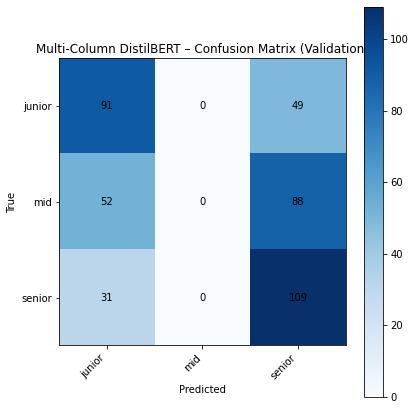

In [ ]:
# Load best model
checkpoint = torch.load(best_model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with F1: {checkpoint['val_f1']:.4f}\n")

# Evaluate on validation set
val_loss, val_acc, val_f1_macro, val_f1_per_class, val_preds, val_labels = evaluate_model(model, val_loader)

print("=" * 60)
print("VALIDATION SET RESULTS")
print("=" * 60)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation F1 (macro): {val_f1_macro:.4f}")
print(f"\nF1 Scores per class:")
for i, label_name in enumerate(label_names):
    print(f"  {label_name}: {val_f1_per_class[i]:.4f}")

# Prediction distribution
pred_counts = Counter(val_preds)
print(f"\nPrediction distribution:")
for i in range(NUM_CLASSES):
    count = pred_counts.get(i, 0)
    print(f"  {id2label[i]}: {count} ({100*count/len(val_preds):.1f}%)")

# Classification report
print(f"\n{'='*60}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'='*60}")
print(classification_report(val_labels, val_preds, target_names=label_names))

# Confusion Matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(val_labels, val_preds)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(conf_matrix, cmap='Blues')

ax.set_xticks(range(NUM_CLASSES))
ax.set_yticks(range(NUM_CLASSES))
ax.set_xticklabels(label_names, rotation=45, ha='right')
ax.set_yticklabels(label_names)

# Add text annotations
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        text = ax.text(j, i, conf_matrix[i, j],
                      ha="center", va="center", color="black")

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix - Validation Set')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print("\n✓ Training and evaluation complete!")
